# End-to-End Sentiment Analysis Project

# 1)-Importing key modules

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import pickle
import numpy as np


In [3]:
import matplotlib.pyplot as plt
from pprint import pprint
plt.style.use('fivethirtyeight')
from wordcloud import WordCloud

In [4]:
from bs4 import BeautifulSoup
import re
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer()


# 2)-Loading Dataset

The dataset can be downloaded from the below link. <br>
http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip

First, columns names have been assigned to each column.

In [5]:
cols = ['sentiment','id','date','query_string','user','text']

In [6]:
df = pd.read_csv("training.1600000.processed.noemoticon.csv",header=None, names=cols,encoding="ISO-8859-1")

In [7]:
df.head()

,sentiment,id,date,query_string,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
sentiment       1600000 non-null int64
id              1600000 non-null int64
date            1600000 non-null object
query_string    1600000 non-null object
user            1600000 non-null object
text            1600000 non-null object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [9]:
df.sentiment.value_counts()

4    800000
0    800000
Name: sentiment, dtype: int64

In [10]:
df.sentiment.value_counts(normalize=True)

4    0.5
0    0.5
Name: sentiment, dtype: float64

training set has no neutral class. 50% of the data is with negative label, and another 50% with positive label

In [11]:
# Checking skewness on the class division.
df.query_string.value_counts()

NO_QUERY    1600000
Name: query_string, dtype: int64

**We shall clear all those unwanted columns for our analysis and also for preprocessing**

In [12]:
df=df[["sentiment","text"]]

In [13]:
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [14]:
df['sentiment'] = df['sentiment'].map({0: 0, 4: 1})

0 for negative <br>
1 for positive

In [15]:
df[df.sentiment == 0].head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [16]:
df[df.sentiment == 1].head()

,sentiment,text
800000,1,I LOVE @Health4UandPets u guys r the best!!
800001,1,im meeting up with one of my besties tonight! ...
800002,1,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,1,Being sick can be really cheap when it hurts t...
800004,1,@LovesBrooklyn2 he has that effect on everyone


By looking at some entries for each class, it seems like that all the negative class is from 0~799999th index, and the positive class entries start from 800000 to the end of the dataset.

In [17]:
df[df.sentiment == 0].index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            799990, 799991, 799992, 799993, 799994, 799995, 799996, 799997,
            799998, 799999],
           dtype='int64', length=800000)

In [18]:
df[df.sentiment == 1].index

Int64Index([ 800000,  800001,  800002,  800003,  800004,  800005,  800006,
             800007,  800008,  800009,
            ...
            1599990, 1599991, 1599992, 1599993, 1599994, 1599995, 1599996,
            1599997, 1599998, 1599999],
           dtype='int64', length=800000)

# 3)-Data Preprocessing

let's look at the length of the string in text column in each entry.

In [19]:
df['pre_clean_len'] = [len(t) for t in df.text]

In [20]:
df.head()

,sentiment,text,pre_clean_len
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",115
1,0,is upset that he can't update his Facebook by ...,111
2,0,@Kenichan I dived many times for the ball. Man...,89
3,0,my whole body feels itchy and like its on fire,47
4,0,"@nationwideclass no, it's not behaving at all....",111


### Data Dictionary

In [21]:
from pprint import pprint
data_dict = {
    'sentiment':{
        'type':df.sentiment.dtype,
        'description':'sentiment class - 0:negative, 1:positive'
    },
    'text':{
        'type':df.text.dtype,
        'description':'tweet text'
    },
    'pre_clean_len':{
        'type':df.pre_clean_len.dtype,
        'description':'Length of the tweet before cleaning'
    },
    'dataset_shape':df.shape
}

pprint(data_dict)

{'dataset_shape': (1600000, 3),
 'pre_clean_len': {'description': 'Length of the tweet before cleaning',
                   'type': dtype('int64')},
 'sentiment': {'description': 'sentiment class - 0:negative, 1:positive',
               'type': dtype('int64')},
 'text': {'description': 'tweet text', 'type': dtype('O')}}


### plot pre_clean_len with box plot 
    
so that I can see the overall distribution of length of strings in each entry.

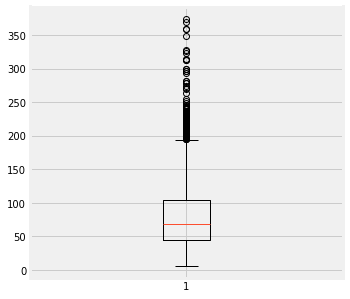

In [22]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(df.pre_clean_len)
plt.show()

**This looks a bit strange, since the twitter's character limit is 140. But from the above box plot, some of the tweets are way more than 140 chracters long.**

In [23]:
df[df.pre_clean_len > 140].head()

,sentiment,text,pre_clean_len
213,0,Awwh babs... you look so sad underneith that s...,142
226,0,Tuesdayï¿½ll start with reflection ï¿½n then a...,141
279,0,Whinging. My client&amp;boss don't understand ...,145
343,0,@TheLeagueSF Not Fun &amp; Furious? The new ma...,145
400,0,#3 woke up and was having an accident - &quot;...,144


In [24]:
len(df[df.pre_clean_len > 140])

17174

So we have 17174 values greater than 140 characters

### Step1-HTML decoding

It looks like HTML encoding has not been converted to text, and ended up in text field as '&amp','&quot',etc.
Decoding HTML to general text will be my first step of data preparation. I will use BeautifulSoup for this.

In [25]:
df.text[279]

"Whinging. My client&amp;boss don't understand English well. Rewrote some text unreadable. It's written by v. good writer&amp;reviewed correctly. "

In [26]:
from bs4 import BeautifulSoup
example1 = BeautifulSoup(df.text[279], 'lxml')
print(example1.get_text())

Whinging. My client&boss don't understand English well. Rewrote some text unreadable. It's written by v. good writer&reviewed correctly. 


&amp has been removed

### Step2- @mention

The second part of the preparation is dealing with @mention.
Even though @mention carries a certain information (which another user that the tweet mentioned), this information doesn't add value to build sentiment analysis model.

In [27]:
df.text[343]

'@TheLeagueSF Not Fun &amp; Furious? The new mantra for the Bay 2 Breakers? It was getting 2 rambunctious;the city overreacted &amp; clamped down '

In [28]:
import re
re.sub(r'@[A-Za-z0-9]+','',df.text[343])

' Not Fun &amp; Furious? The new mantra for the Bay 2 Breakers? It was getting 2 rambunctious;the city overreacted &amp; clamped down '

### Step3- URL links

The third part of the cleaning is dealing with URL links, same with @mention, even though it carries some information, for sentiment analysis purpose, this can be ignored.

In [29]:
df.text[0]

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [30]:
# using regular expression
re.sub('https?://[A-Za-z0-9./]+','',df.text[0])

"@switchfoot  - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

### Step 4- UTF-8 BOM (Byte Order Mark)

In [31]:
#df.text[226]

By looking at the above entry, I can see strange patterns of characters "\xef\xbf\xbd". After some researching, I found that these are UTF-8 BOM.
"The UTF-8 BOM is a sequence of bytes (EF BB BF) that allows the reader to identify a file as being encoded in UTF-8."

By decoding text with 'utf-8-sig', this BOM will be replaced with unicode unrecognizable special characters, then I can process this as "?"

In [32]:
#testing = df.text[226].decode("utf-8-sig")
#testing

In [33]:
#type(df.text[226])

In [34]:
#testing.replace(u"\ufffd", "?")

### Step5- hashtag / numbers

Sometimes the text used with a hashtag can provide useful information about the tweet. It might be a bit risky to get rid of all the text together with the hashtag.
So I decided to leave the text intact and just remove the '#'. I will do this in the process of cleaning all the non-letter characters including numbers.

In [35]:
df.text[175]

"@machineplay I'm so sorry you're having to go through this. Again.  #therapyfail"

In [36]:
re.sub("[^a-zA-Z]", " ", df.text[175])

' machineplay I m so sorry you re having to go through this  Again    therapyfail'

# All in one step

Defining data cleaning function:
    
With above five data cleaning task, I will first define data cleaning function, and then will be applied to the whole dataset. Tokenization, stemming/lemmatization, stop words will be dealt with later stage when creating matrix with either count vectorizer or Tfidf vectorizer.


In [37]:
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()


In [38]:
part1 = r'@[A-Za-z0-9_]+'
part2 = r'https?://[^ ]+'
combined_pat = r'|'.join((part1, part2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

In [39]:
testing = df.text[:100]

In [40]:
test_result = []
for t in testing:
    test_result.append(tweet_cleaner(t))

In [41]:
test_result[0]

'awww that bummer you shoulda got david carr of third day to do it'

In [42]:
type(test_result)

list

In [43]:
pd.DataFrame(test_result).head()

,0
0,awww that bummer you shoulda got david carr of...
1,is upset that he can not update his facebook b...
2,dived many times for the ball managed to save ...
3,my whole body feels itchy and like its on fire
4,no it not behaving at all mad why am here beca...


# Apply clean function to full dataset

In [45]:
%%time
print ("Cleaning and parsing the tweets...\n")
clean_tweet_texts = []
for i in range(0,len(df)):
    if( (i+1)%100000 == 0 ):
        print ("Tweets %d of %d has been processed" % ( i+1, len(df) ))                                                                    
    clean_tweet_texts.append(tweet_cleaner(df['text'][i]))

Cleaning and parsing the tweets...

Tweets 100000 of 1600000 has been processed
Tweets 200000 of 1600000 has been processed
Tweets 300000 of 1600000 has been processed
Tweets 400000 of 1600000 has been processed
Tweets 500000 of 1600000 has been processed
Tweets 600000 of 1600000 has been processed
Tweets 700000 of 1600000 has been processed
Tweets 800000 of 1600000 has been processed
Tweets 900000 of 1600000 has been processed
Tweets 1000000 of 1600000 has been processed
Tweets 1100000 of 1600000 has been processed
Tweets 1200000 of 1600000 has been processed
Tweets 1300000 of 1600000 has been processed
Tweets 1400000 of 1600000 has been processed
Tweets 1500000 of 1600000 has been processed
Tweets 1600000 of 1600000 has been processed
Wall time: 11min 21s


# Saving cleaned data as csv

In [46]:
clean_df = pd.DataFrame(clean_tweet_texts,columns=['text'])
clean_df['target'] = df.sentiment
clean_df.head()

,text,target
0,awww that bummer you shoulda got david carr of...,0
1,is upset that he can not update his facebook b...,0
2,dived many times for the ball managed to save ...,0
3,my whole body feels itchy and like its on fire,0
4,no it not behaving at all mad why am here beca...,0


In [47]:
clean_df.to_pickle('clean_data_tweet.pkl')

In [48]:
clean_df.to_csv('clean_tweet.csv',encoding='utf-8')

In [49]:
csv = 'clean_tweet.csv'
my_df = pd.read_csv(csv,index_col=0)
my_df.head()

,text,target
0,awww that bummer you shoulda got david carr of...,0
1,is upset that he can not update his facebook b...,0
2,dived many times for the ball managed to save ...,0
3,my whole body feels itchy and like its on fire,0
4,no it not behaving at all mad why am here beca...,0


In [50]:
df = pd.read_pickle('clean_data_tweet.pkl')

In [51]:
my_df.head()

,text,target
0,awww that bummer you shoulda got david carr of...,0
1,is upset that he can not update his facebook b...,0
2,dived many times for the ball managed to save ...,0
3,my whole body feels itchy and like its on fire,0
4,no it not behaving at all mad why am here beca...,0


In [52]:
my_df.shape

(1600000, 2)

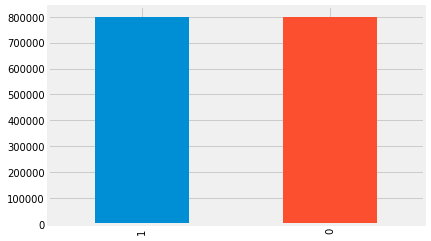

In [53]:
my_df.target.value_counts().plot(kind='bar')

# 4)- Checking missing values 

In [54]:
my_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
text      1596041 non-null object
target    1600000 non-null int64
dtypes: int64(1), object(1)
memory usage: 36.6+ MB


text      1596041 non-null object

In [55]:
my_df[my_df.isnull().any(axis=1)].head()

,text,target
208,NaN,0
249,NaN,0
282,NaN,0
398,NaN,0
430,NaN,0


In [56]:
len(my_df[my_df.isnull().any(axis=1)])

3959

In [57]:
np.sum(my_df.isnull().any(axis=1))

3959

In [58]:
my_df.isnull().any(axis=0)

text       True
target    False
dtype: bool

It seems like 3959 entries have null entries for the text column. This is strange, because the original dataset had no null entries, and if there are any null entries in the cleaned dataset, it must have happened during the cleaning process.

In [59]:
df = pd.read_csv("training.1600000.processed.noemoticon.csv",header=None, names=cols,encoding="ISO-8859-1")
df.iloc[my_df[my_df.isnull().any(axis=1)].index,:].head()

,sentiment,id,date,query_string,user,text
208,0,1467863072,Mon Apr 06 22:33:25 PDT 2009,NO_QUERY,Artiel87,@mandayyy
249,0,1467874569,Mon Apr 06 22:36:27 PDT 2009,NO_QUERY,Artiel87,@mandayyy
282,0,1467881474,Mon Apr 06 22:38:20 PDT 2009,NO_QUERY,__Susan__,@ITS_NEMESIS -------
398,0,1467912842,Mon Apr 06 22:46:53 PDT 2009,NO_QUERY,KimberlyKane,@danadearmond
430,0,1467919452,Mon Apr 06 22:48:48 PDT 2009,NO_QUERY,jtmal0723,@anistorm


By looking at these entries in the original data, it seems like only text information they had was either twitter ID or it could have been URL address. Anyway, these are the info I decided to discard for the sentiment analysis, so I will drop these null rows, and update the data frame.

In [60]:
my_df.dropna(inplace=True)
my_df.reset_index(drop=True,inplace=True)
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596041 entries, 0 to 1596040
Data columns (total 2 columns):
text      1596041 non-null object
target    1596041 non-null int64
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [61]:
np.sum(my_df.isnull().any(axis=1))

0

### Confirming if we cleaned well enough

In [62]:
my_df.head()

,text,target
0,awww that bummer you shoulda got david carr of...,0
1,is upset that he can not update his facebook b...,0
2,dived many times for the ball managed to save ...,0
3,my whole body feels itchy and like its on fire,0
4,no it not behaving at all mad why am here beca...,0


In [63]:
my_df['pre_clean_len'] = [len(t) for t in my_df.text]

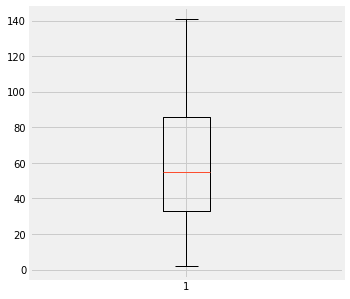

In [64]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(my_df.pre_clean_len)
plt.show()

In [65]:
my_df[my_df.pre_clean_len > 140].head()

,text,target,pre_clean_len
427371,can not seem to wake up today can not have ear...,0,141


In [66]:
len(my_df[my_df.pre_clean_len > 140])

1

In [67]:
my_df.text[427371]

'can not seem to wake up today can not have early night tonight as must watch the apprentice would not be the same watching recording tomorrow'

**Only one value that exceeds the limit. We can remove this row.**

# Saving again for future use

In [68]:
my_df.to_pickle('clean.pkl')

In [69]:
my_df.to_csv('clean.csv',encoding='utf-8')

# 5)- Visulization

Word Cloud

In [70]:
neg_tweets = my_df[my_df.target == 0]
neg_string = []
for t in neg_tweets.text:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

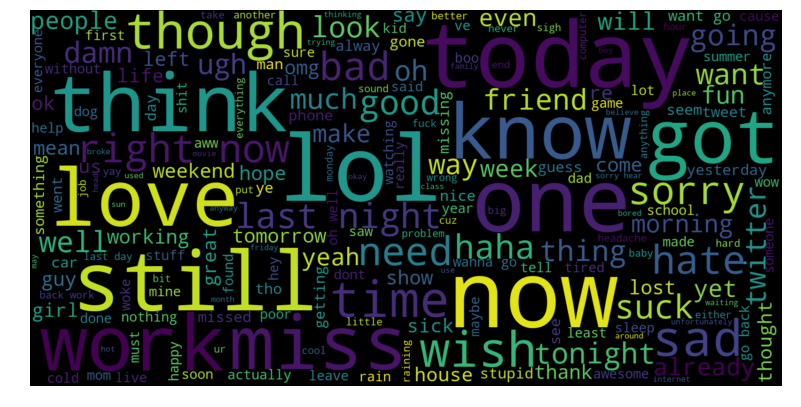

In [71]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Some of the big words can be interpreted quite neutral, such as "today","now", etc. I can see some of the words in smaller size make sense to be in negative tweets, such as "damn","ugh","miss","bad", etc. But there is "love" in a rather big size, so I wanted to see what is happening

In [72]:
# checking a positive word in negative sentiment
for t in neg_tweets.text[:200]:
    if 'love' in t:
        print (t)

ahh ive always wanted to see rent love the soundtrack
meh almost lover is the exception this track gets me depressed every time
awe love you too am here miss you
damn the grind is inspirational and saddening at the same time do not want you to stop cuz like what do much love
missing you babe but as long as your alive happy ya tired my love imma try to sleep hopefully you had headstart
love the french tell people here in the south qtr french and they snarl at me french are beautiful people


**even though the tweets contain the word "love", in these cases it is negative sentiment because the tweet has mixed emotions like "love" but "miss". Or sometimes used in a sarcastic way.**

In [73]:
pos_tweets = my_df[my_df.target == 1]
pos_string = []
for t in pos_tweets.text:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')

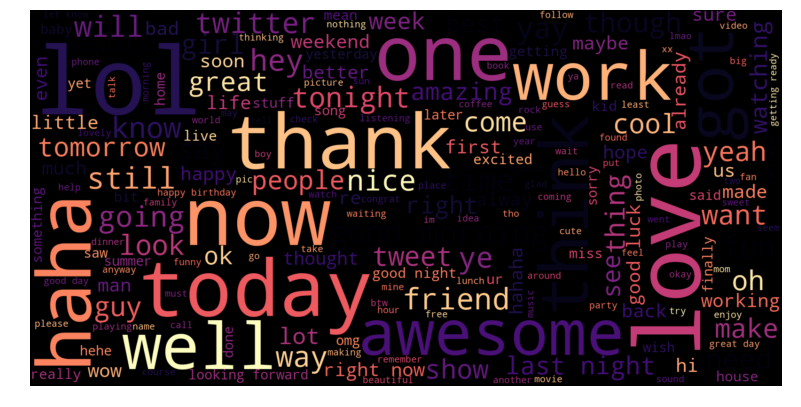

In [74]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(pos_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Again I see some neutral words in big size, "today","now", but words like "haha", "love", "awesome" also stand out.

In [75]:
# checking "work" word in neg. sentiments
for t in neg_tweets.text[:200]:
    if 'work' in t:
        print (t)

thought sleeping in was an option tomorrow but realizing that it now is not evaluations in the morning and work in the afternoon
ill tell ya the story later not good day and ill be workin for like three more hours
bed class work gym or then class another day that gonna fly by miss my girlfriend
just leaving the parking lot of work
sure you re right need to start working out with you and the nikster or jared at least
my tummy hurts wonder if the hypnosis has anything to do with it if so it working get it stop smoking
you do not follow me either and work for you
behind on my classes for work
wah can not see clip must be el stupido work filters can not wait till get puter something else blame ex he broke mine
no no notice they told me be working tomorrow and then called the agency to follow up and they said it was over
man work is hard
no phantasy star yesterday going to work
is alone downstairs working
currently at work


In [76]:
for t in pos_tweets.text[:200]:
    if 'work' in t:
        print (t)

can not get up early enough night workouts are much better
bonjour spacecowboy wish was either of it work with kids can go out whenever want and go wherever want to
nikki is off working her ass off on bike trying to recover from her knee injury good for her
listening to some music and just chilling ll probably regret not getting work done but till then just gonna kick back
just started to work but it the last one before holidayholiday
am working on my media room design and love love love my client profile
working on setting up my ipod touch which as of today is officially mine
saw the tvc yesterday worked for me
callin it night always have the best sleep after good workout
the gym is an awesome place work it out


Interestingly, the word "work" was quite big in the negative word cloud, but also quite big in the positive word cloud. It might imply that many people express negative sentiment towards work, but also many people are positive about works.

### b)-term frequency

In order for me to implement a couple of data visualisation in the next step, I need term frequency data. What kind of words are used in the tweets, and how many times it is used in entire corpus. I used count vectorizer to calculate the term frequencies, the count vectorizer is also for fit, train and predict, but at this stage, I will just be extracting the term frequencies for the visualisation.

In [77]:
#There are parameter options available for count vectorizer, such as removing stop words, limiting the maximum number of terms. However, in order to get a full picture of the dataset first, I implemented with stop words included, and not limiting the maximum number of terms.

from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer()
cvec.fit(my_df.text)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [78]:
len(cvec.get_feature_names())

264939

In [79]:
neg_doc_matrix = cvec.transform(my_df[my_df.target == 0].text)
pos_doc_matrix = cvec.transform(my_df[my_df.target == 1].text)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=cvec.get_feature_names())

In [80]:
term_freq_df.head()

,aa,aaa,aaaa,aaaaa,aaaaaa,aaaaaaa,aaaaaaaa,aaaaaaaaa,aaaaaaaaaa,aaaaaaaaaaa,...,zzzzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz
0,160,93,45,26,16,9,13,6,6,4,...,1,1,0,1,0,0,0,0,1,1
1,92,54,29,12,12,1,0,2,3,1,...,1,0,1,2,1,1,3,1,0,0


In [81]:
term_freq_df=term_freq_df.transpose()

In [82]:
term_freq_df.head()

,0,1
aa,160,92
aaa,93,54
aaaa,45,29
aaaaa,26,12
aaaaaa,16,12


In [83]:
term_freq_df.columns = ['negative', 'positive']

In [84]:
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']

In [85]:
term_freq_df.head()

,negative,positive,total
aa,160,92,252
aaa,93,54,147
aaaa,45,29,74
aaaaa,26,12,38
aaaaaa,16,12,28


In [86]:
term_freq_df.sort_values(by='total', ascending=False).head()

,negative,positive,total
to,313162,252567,565729
the,257836,265998,523834
my,190775,125955,316730
it,157448,147786,305234
and,153958,149642,303600


In [87]:
len(term_freq_df)

264939

In [88]:
term_freq_df.shape

(264939, 3)

In [89]:
term_freq_df.to_pickle('term_freq_mat.pkl')